In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.two_player_dubins_car import TwoPlayerDubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

In [119]:
#generate data

x_a = np.linspace(-4,4, 15)
y_a = np.linspace(-4,4, 15)
theta_a = np.linspace(0,2*np.pi, 15)

x_d = np.linspace(0,0, 1)
y_d = np.linspace(0,0, 1)
theta_d = np.linspace(np.pi,np.pi, 1)

xx_a, yy_a, tt_a, xx_d, yy_d, tt_d = np.meshgrid(x_a, y_a, theta_a, x_d, y_d, theta_d)
grid = np.vstack([xx_a.ravel(), yy_a.ravel(), tt_a.ravel(), xx_d.ravel(), yy_d.ravel(), tt_d.ravel()]).T



In [120]:
grid

array([[-4.        , -4.        ,  0.        ,  0.        ,  0.        ,
         3.14159265],
       [-4.        , -4.        ,  0.44879895,  0.        ,  0.        ,
         3.14159265],
       [-4.        , -4.        ,  0.8975979 ,  0.        ,  0.        ,
         3.14159265],
       ...,
       [ 4.        ,  4.        ,  5.38558741,  0.        ,  0.        ,
         3.14159265],
       [ 4.        ,  4.        ,  5.83438636,  0.        ,  0.        ,
         3.14159265],
       [ 4.        ,  4.        ,  6.28318531,  0.        ,  0.        ,
         3.14159265]])

In [121]:
X = []
env = TwoPlayerDubinsCarEnv()
for g in grid:
    state = env.set(*g)
    print(state)
    X.append(state.copy())


{'attacker': array([-4., -4.,  0.], dtype=float32), 'defender': array([0.       , 0.       , 3.1415927], dtype=float32)}
{'attacker': array([-4.        , -4.        ,  0.44879895], dtype=float32), 'defender': array([0.       , 0.       , 3.1415927], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  0.8975979], dtype=float32), 'defender': array([0.       , 0.       , 3.1415927], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  1.3463968], dtype=float32), 'defender': array([0.       , 0.       , 3.1415927], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  1.7951958], dtype=float32), 'defender': array([0.       , 0.       , 3.1415927], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  2.2439947], dtype=float32), 'defender': array([0.       , 0.       , 3.1415927], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  2.6927936], dtype=float32), 'defender': array([0.       , 0.       , 3.1415927], dtype=float32)}
{'attacker': array([-4. 

In [122]:
y_true = [env.get_attacker_max_reward(state) for state in X]
y_true = np.array(y_true)
y_true[y_true == -np.inf] = -1
print(sum(y_true))

216.0


In [123]:
y_true.shape

(3375,)

In [124]:
import seaborn as sns
sns.distplot(y_true)

/tmp/ipykernel_2387602/2964622613.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_true)


<AxesSubplot: ylabel='Density'>

In [125]:
# %%capture
# #generate data
# env = TwoPlayerDubinsCarEnv()

# state = env.reset()
# X = []
# y = []
# for i in range(20000):
#     for player in env.players:
#         state = env.reset()
#         action = env.action_space[player].sample() 
#         X.append(np.hstack([state['attacker'], state['defender']]))
#         r = env.sample(state, action, player,0.5)
#         y.append(r)

# X = np.array(X)
# y = np.array(y)

# print(X[:5])
# print(y[:5])


In [126]:
X[2000]

{'attacker': array([3.4285715, 0.5714286, 2.2439947], dtype=float32),
 'defender': array([0.       , 0.       , 3.1415927], dtype=float32)}

In [127]:
import matplotlib.colors as mcolors

def plot_surface(X_in, env, file_name=None, y_pred=None, ys=None):
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [15, 12]

    # Plot...
    plt.scatter(X_in[:,0], X_in[:,1], s=1) # s is a size of marker 
    plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
    plt.gca().add_artist(obstacle)
    plt.gca().add_artist(goal)

    arrow_len = env.v_max
    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(X_in[:,2])
    arrow_dy = arrow_len * np.sin(X_in[:,2])

    if y_pred:
        norm = mcolors.Normalize(vmin=np.min(y_pred), vmax=np.max(y_pred))
        arrow_colors = cm.jet(norm(y_pred))
    elif len(ys) > 0:
        norm = mcolors.Normalize(vmin=np.min(ys), vmax=np.max(ys))
        arrow_colors = cm.jet(norm(ys))
    else:
        arrow_colors = 'k'

    plt.quiver(X_in[:,0], X_in[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)

    if file_name:
        plt.savefig(file_name)


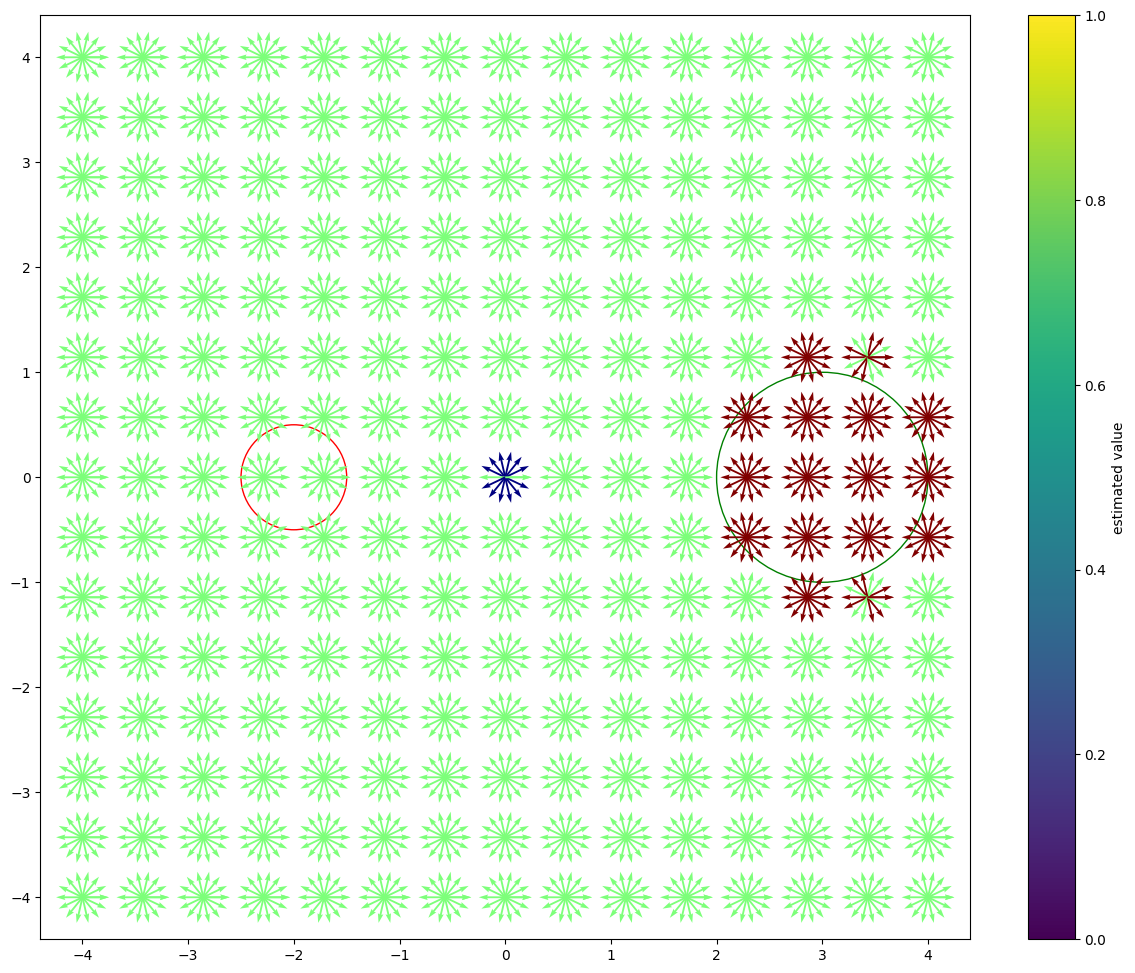

In [128]:
X_attacker = np.array([x['attacker'] for x in X])
plot_surface(X_attacker, env, None, [], y_true)

In [129]:
X

[{'attacker': array([-4., -4.,  0.], dtype=float32),
  'defender': array([0.       , 0.       , 3.1415927], dtype=float32)},
 {'attacker': array([-4.        , -4.        ,  0.44879895], dtype=float32),
  'defender': array([0.       , 0.       , 3.1415927], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  0.8975979], dtype=float32),
  'defender': array([0.       , 0.       , 3.1415927], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.3463968], dtype=float32),
  'defender': array([0.       , 0.       , 3.1415927], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.7951958], dtype=float32),
  'defender': array([0.       , 0.       , 3.1415927], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  2.2439947], dtype=float32),
  'defender': array([0.       , 0.       , 3.1415927], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  2.6927936], dtype=float32),
  'defender': array([0.       , 0.       , 3.1415927], dtype=float32

In [130]:
def encode(X):
    X = np.array(list(map(lambda row: (row['attacker'][0], row['attacker'][1], np.cos(row['attacker'][2]), np.sin(row['attacker'][2]), row['defender'][0], row['defender'][1], np.cos(row['defender'][2]), np.sin(row['defender'][2])), X)))

    return X

X = encode(X)
X


array([[-4.0000000e+00, -4.0000000e+00,  1.0000000e+00, ...,
         0.0000000e+00, -1.0000000e+00, -8.7422777e-08],
       [-4.0000000e+00, -4.0000000e+00,  9.0096885e-01, ...,
         0.0000000e+00, -1.0000000e+00, -8.7422777e-08],
       [-4.0000000e+00, -4.0000000e+00,  6.2348980e-01, ...,
         0.0000000e+00, -1.0000000e+00, -8.7422777e-08],
       ...,
       [ 4.0000000e+00,  4.0000000e+00,  6.2348962e-01, ...,
         0.0000000e+00, -1.0000000e+00, -8.7422777e-08],
       [ 4.0000000e+00,  4.0000000e+00,  9.0096885e-01, ...,
         0.0000000e+00, -1.0000000e+00, -8.7422777e-08],
       [ 4.0000000e+00,  4.0000000e+00,  1.0000000e+00, ...,
         0.0000000e+00, -1.0000000e+00, -8.7422777e-08]], dtype=float32)

In [131]:
print(len(X))


3375


In [132]:
# %%capture
# #generate data
# env = TwoPlayerDubinsCarEnv()

# state = env.reset()
# X = []
# y = []
# for i in range(50000):
#     for player in env.players:
#         state = env.reset()
#         X.append(np.hstack([state['attacker'], state['defender']]))


# X = np.array(X)



In [133]:
len(X)

3375

In [134]:

def forward(X):
    l1 = hk.Linear(128)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(128)(l2)
    l4 = jax.nn.relu(l3)
    l5 = hk.Linear(128)(l4)
    l6 = jax.nn.relu(l5)

    l7 = hk.Linear(128)(l6)
    l8 = jax.nn.relu(l7)

    l9 = hk.Linear(1)(l8)
    return l9

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse




optimizer = optax.adamw(learning_rate=10e-5)
batch_size = 100 #make it 200
losses = [np.inf]
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)
gamma = 0.85

@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

FIRST = False

for epoch in range(25):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]


        if FIRST:
            y_batch = ys[batch:batch+batch_size]
            #print(np.unique(y_batch, return_counts=True))
        else:
            y_batch = env.sample_value_iter(X_batch, forward, params, gamma=gamma)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    FIRST = False
    epoch_loss /= (len(X) // batch_size)

    # y_val = env.sample_value_iter(X_val, forward, params, gamma=gamma)

    # val_loss = loss_fn(params, X_val, y_val)
    # print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    # if val_losses[-1] - val_loss < 0.0001:
    #     print("early stopping",val_losses[-1] - val_loss)
    #     break
    # val_losses.append(val_loss)


    print('epoch', epoch, 'average loss', epoch_loss, 'epoch delta', np.abs(epoch_loss - losses[-1]))
    losses.append(epoch_loss)

#todo impolement val set for early stopping


epoch 0 average loss 0.09442786 epoch delta inf
epoch 1 average loss 0.09403164 epoch delta 0.00039622188
epoch 2 average loss 0.08957308 epoch delta 0.0044585615
epoch 3 average loss 0.0861828 epoch delta 0.003390275
epoch 4 average loss 0.0844681 epoch delta 0.0017147064
epoch 5 average loss 0.08332612 epoch delta 0.0011419728
epoch 6 average loss 0.08263859 epoch delta 0.0006875321
epoch 7 average loss 0.08186568 epoch delta 0.00077290833
epoch 8 average loss 0.08141019 epoch delta 0.00045549124
epoch 9 average loss 0.0805409 epoch delta 0.00086928904
epoch 10 average loss 0.0802391 epoch delta 0.00030180067
epoch 11 average loss 0.07948956 epoch delta 0.0007495433
epoch 12 average loss 0.079544015 epoch delta 5.4456294e-05
epoch 13 average loss 0.079540186 epoch delta 3.8295984e-06
epoch 14 average loss 0.07880467 epoch delta 0.00073551387
epoch 15 average loss 0.07929275 epoch delta 0.00048808008
epoch 16 average loss 0.07916341 epoch delta 0.00012934208
epoch 17 average loss 0.07

KeyboardInterrupt: 

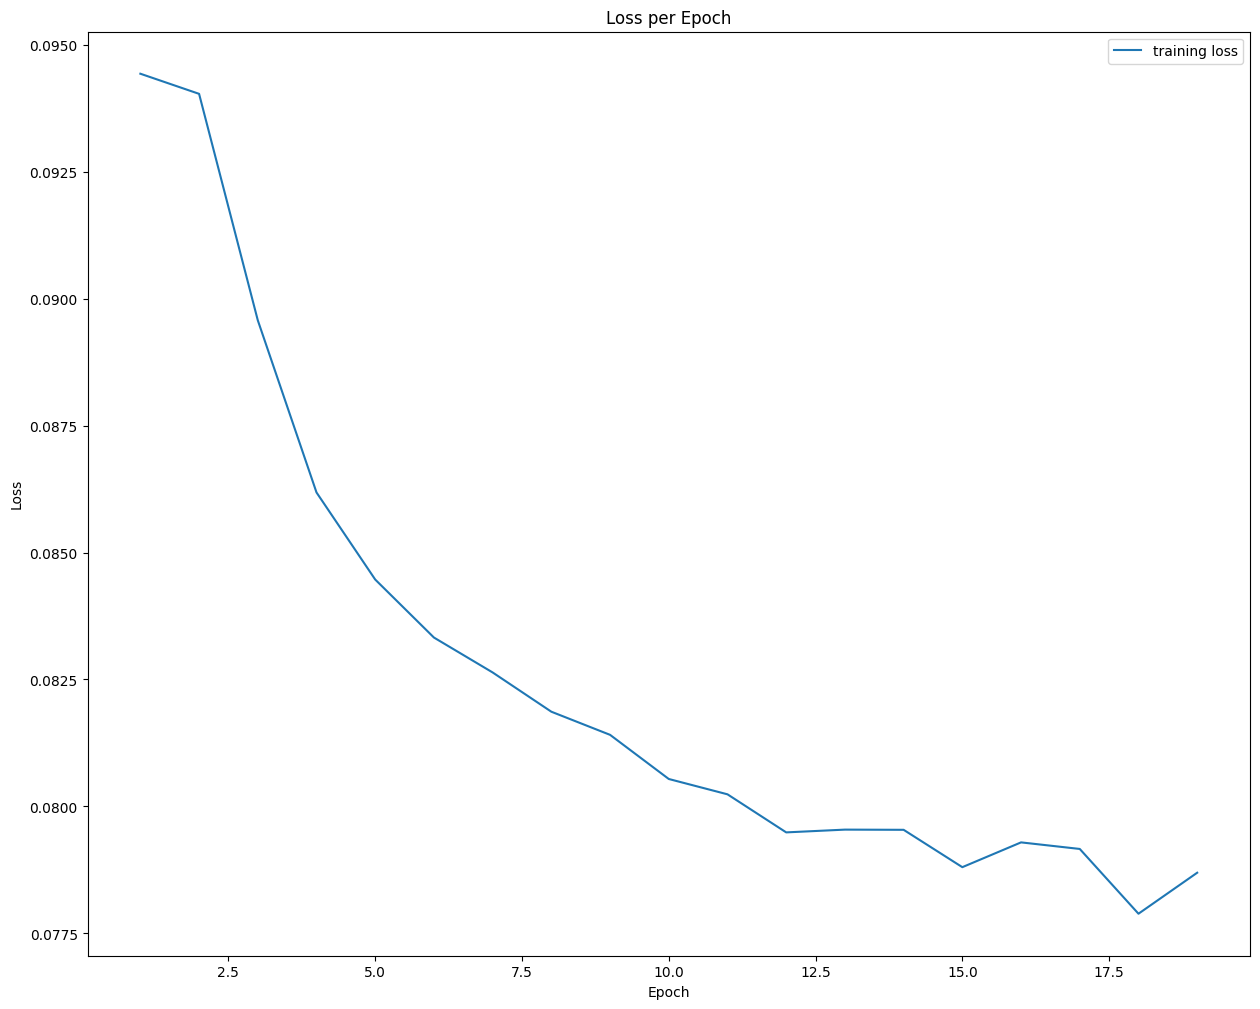

In [135]:
# Plot the losses
%matplotlib inline



plt.plot(losses, label='training loss')
#plt.plot(vlo, label='validation loss')

# Add a title and labels to the x and y axis
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot

plt.show()

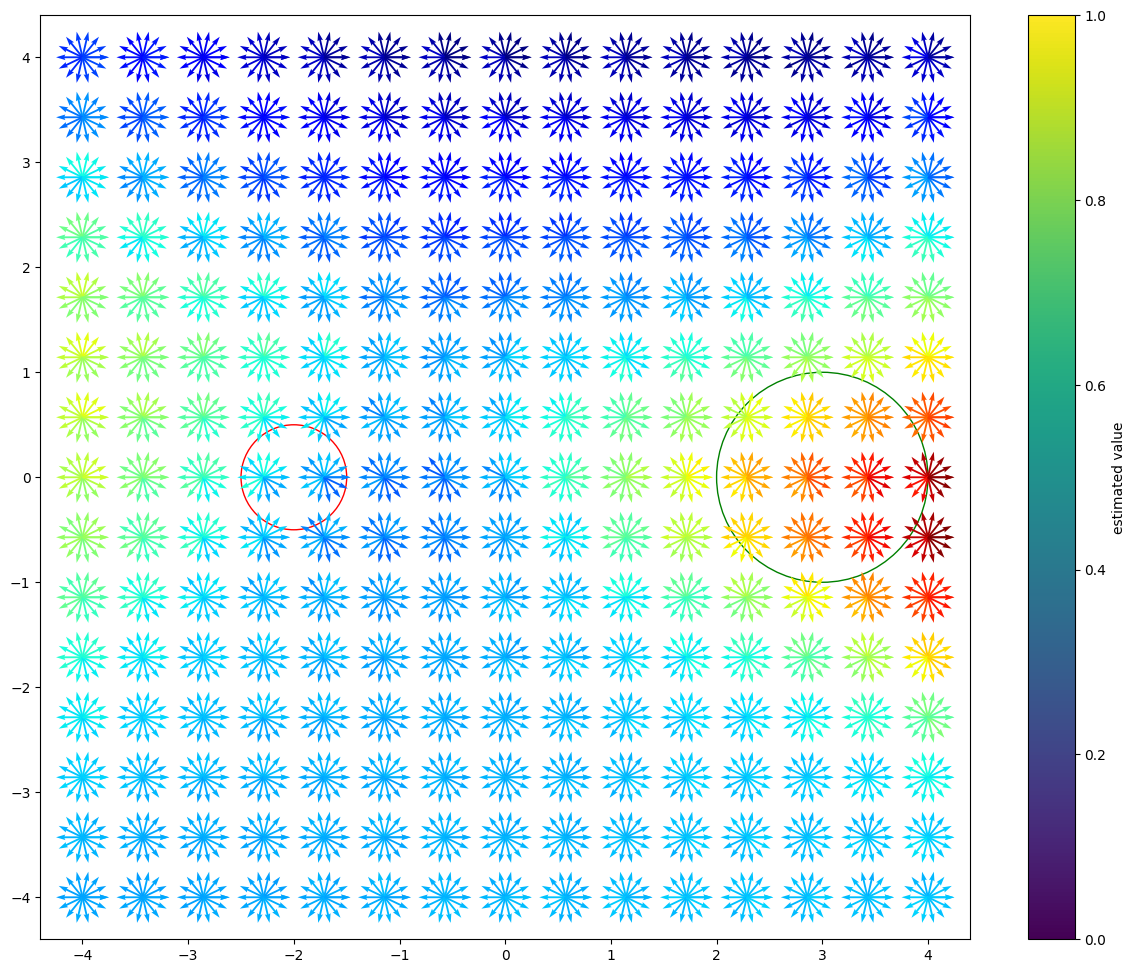

In [136]:

y_train = [forward(X=x, params=params) for x in X]
plot_surface(X_attacker, env, 'experiment2.png', y_train)

In [106]:
# env = TwoPlayerDubinsCarEnv()
# state = env.reset()
# done = False
# max_iter = 50
# counter = 0
# print(env.state)
# while (not done) and (counter < max_iter):
#     counter+=1
#     possible_actions = []
#     for d_action in range(env.action_space['defender'].n):
#         state_ , reward, done, info = env.step(state, d_action, 'defender')
#         defender_actions = []
#         for a_action in range(env.action_space['attacker'].n):
#             next_state, reward, _, _ = env.step(state_, a_action, 'attacker')
#             #input = np.hstack([next_state['attacker'], next_state['defender']])
#             nn_input = env.state_for_nn(next_state)
#             estimate  = forward(X=nn_input, params=params)
#             print('estimate', estimate, 'actual', reward)
#             possible_actions.append([d_action, a_action, estimate[0]])
#         pa = np.array(possible_actions)
#     cand_attack_actions = np.argmax(pa.T,axis=0)
#     best_defender_action =  np.argmin(np.max(pa.T,axis=0))
#     best_attacker_action = cand_attack_actions[best_defender_action]
#     print(counter)
#     print('best defender action', best_defender_action, 'best attacker action', best_attacker_action)
#     print(env.state)

#     state, reward, done, _ = env.step(action=best_defender_action, player='defender', update_env=True)
#     #state, reward, done, _ = env.step(action=best_attacker_action, player='attacker', update_env=True)

#     env.render()
    
# env.make_gif()

In [148]:
right = 0.0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = TwoPlayerDubinsCarEnv()
state = env.reset()
#state = env.set(-3, 3, down,-2, 2, up)

#state = env.set(0, 2, down,0, 0, right)
done = False
max_iter = 100
counter = 0
print(env.state)

while (not done) and (counter < max_iter):
    counter += 1
    pa = []
    for d_action in range(env.action_space['defender'].n):
        possible_actions = []  # Initialize possible_actions inside the d_action loop
        state_, reward, done, defender_info = env.step(state, d_action, 'defender')
        for a_action in range(env.action_space['attacker'].n):
            next_state, reward, done, info_attacker = env.step(state_, a_action, 'attacker')

            if info_attacker['player'] == 'attacker' and not info_attacker['is_legal']:
                possible_actions.append([d_action, a_action, -np.inf])
                print('illegal move')
                # If the attacker's move is illegal, skip it
            elif defender_info['status'] == 'eaten':
                done = True
                possible_actions.append([d_action, a_action, -1])
                print('eaten')
                

            else:
                nn_input = env.state_for_nn(next_state)
                estimate = forward(X=nn_input, params=params)
                possible_actions.append([d_action, a_action, estimate[0]])
        pa.append(possible_actions)

    pa = np.array(pa)[:, :, 2].T
    if np.all(pa == -np.inf):
        print('all illegal moves')
        break
    if np.any(pa == -1):
        print('eaton, defemder wins')
        break


    cand_attack_actions = np.argmax(pa, axis=0)
    best_defender_action = np.argmin(np.max(pa, axis=0))
    best_attacker_action = cand_attack_actions[best_defender_action]
    print(counter)
    print('best defender action', best_defender_action, 'best attacker action', best_attacker_action)
    print(env.state)

    state, reward, done, _ = env.step(action=best_defender_action, player='defender', update_env=True)
    state, reward, done, _ = env.step(action=best_attacker_action, player='attacker', update_env=True)

    env.render()
    
env.make_gif()


{'attacker': array([0.2015015, 2.68027  , 1.6145879], dtype=float32), 'defender': array([0.       , 0.       , 3.1415927], dtype=float32)}
1
best defender action 2 best attacker action 3
{'attacker': array([0.2015015, 2.68027  , 1.6145879], dtype=float32), 'defender': array([0.       , 0.       , 3.1415927], dtype=float32)}
2
best defender action 1 best attacker action 0
{'attacker': array([0.21244594, 2.4305096 , 4.756181  ], dtype=float32), 'defender': array([ 2.9812202e-09, -2.5000000e-01,  4.7123890e+00], dtype=float32)}
3
best defender action 3 best attacker action 1
{'attacker': array([-0.03731439,  2.4195652 ,  3.1853845 ], dtype=float32), 'defender': array([ 5.9624403e-09, -5.0000000e-01,  4.7123890e+00], dtype=float32)}
4
best defender action 1 best attacker action 1
{'attacker': array([-0.2870747,  2.4086208,  3.1853845], dtype=float32), 'defender': array([-4.9654068e-09, -2.5000000e-01,  1.5707964e+00], dtype=float32)}
5
best defender action 1 best attacker action 1
{'attack

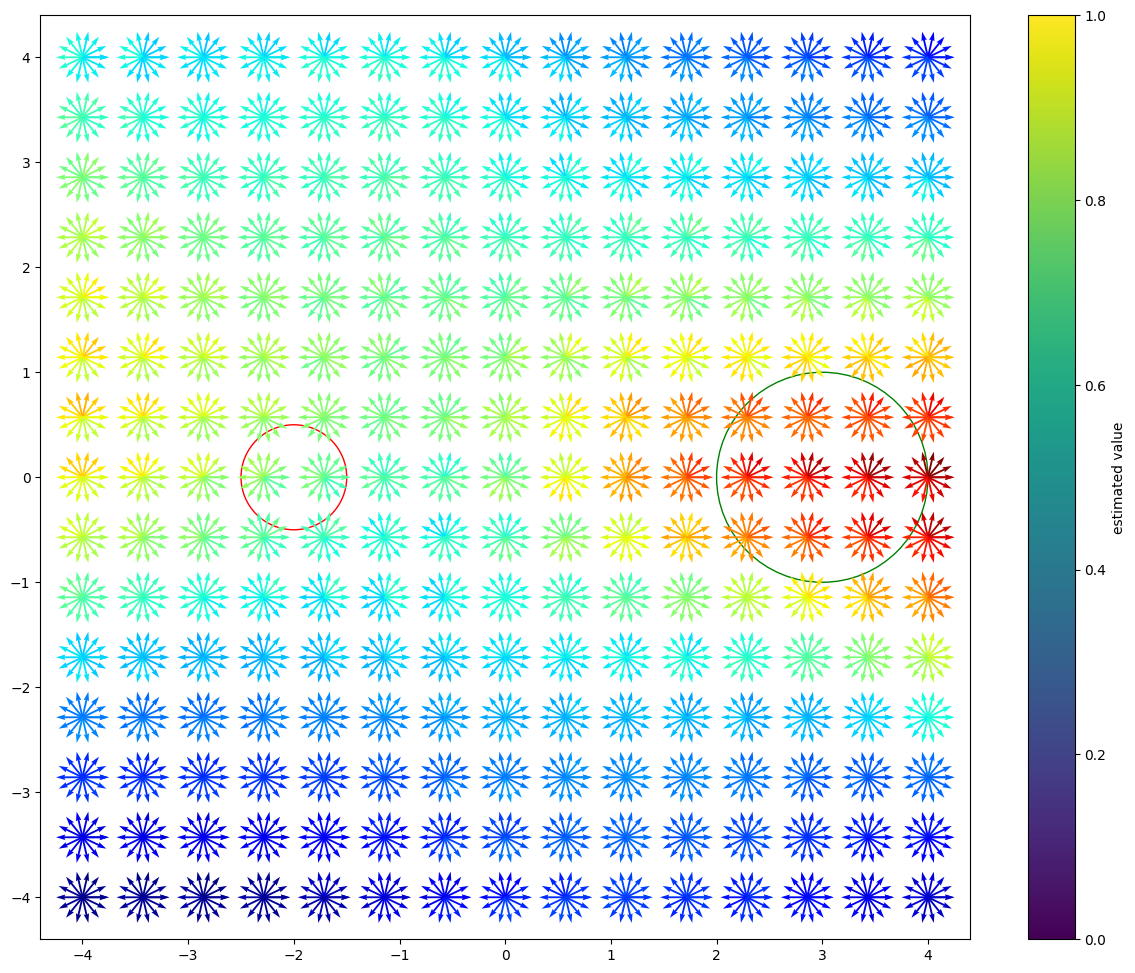

In [ ]:
pa = np.array(possible_actions)
pa = pa[:,2].reshape(3,3)
pa

In [ ]:
best_attacker_moves = np.argmax(pa.T,axis=0)

best_defender_move =  np.argmin(np.max(pa.T,axis=0))

best_attacker_move = best_attacker_moves[best_defender_move]
print(best_defender_move,best_attacker_move)


In [ ]:
pa[best_defender_move][best_attacker_move]

In [ ]:
possible_actions